# Neural Network for Time-Stepping Prediction of Buildings

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import signal
# import math
# import os
import timeit

import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sn

from sklearn.preprocessing import StandardScaler

from tradnet import *

## Set Inputs

In [2]:
seed = 7
n_samples = 10000
num_metaims = 5             # NOTE: Here this variable denotes the number of Intensity Measures to use

In [3]:
path_to_predictor_dataset = '../RC_Frame_large/predictors.parquet'           # Set the path to your analysis data file (csv/parquet)
path_to_pga_dataset = '../RC_Frame_large/pga_all_new.parquet'

## Read Inputs

In [4]:
cols2read = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 
             'f_c', 'gm_index', 'pga', 'pgv', 'tip_displacement']

predictors_all = pd.read_parquet(path_to_predictor_dataset, columns = cols2read, engine = 'pyarrow')
predictors_all = predictors_all[predictors_all['tip_displacement']<48].reset_index(drop = True)

predictors_all['building_ht'] = predictors_all['storeys'] * predictors_all['storey_ht']
predictors_all['building_width'] = predictors_all['bays'] * predictors_all['bay_width']

In [5]:
pga_all = pd.read_parquet(path_to_pga_dataset, engine = 'pyarrow')
predictors_all = predictors_all.merge(pga_all[['sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa20', 'arias', 'sed', 'cav', 'ASI_05', 'ASI_10']], 
                                      left_on = 'gm_index', right_index = True)

We assume the collapse capacity of the building to be 12 inches

In [6]:
capacity = 12
predictors_all['capacity'] = capacity
predictors_all['damage_state'] = 0

predictors_all.loc[predictors_all['tip_displacement']>predictors_all['capacity'], 'damage_state'] = 1

predictors_all = predictors_all.drop(columns = ['storeys', 'storey_ht', 'bays', 'bay_width', 'capacity'])

## Prepare training data

In [7]:
train_data, val_data, test_data = create_train_val_test_splits(predictors_all, 
                                                               n_samples = n_samples, 
                                                               split_frac = 0.9, 
                                                               random_seed = seed)

cols2scale = ['building_ht', 'building_width', 'w_floor', 'f_c']
cols_predicted = ['damage_state']

cols_gm = ['pga', 'pgv', 'arias', 'cav', 'ASI_05']

# cols_gm = ['pga', 'pgv', 'cav', 'sa01', 'sa02', 'ASI_05', 'ASI_10', 'arias']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa20']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa02', 'sa03', 'sa06', 'sa10']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa03', 'sa10']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa03']
# cols_gm = ['pga', 'pgv', 'sa01']
# cols_gm = ['pga', 'pgv']
# cols_gm = ['pga']

x_data, x_val, x_test, y_data, y_val, y_test = create_scaled_inputs_outputs(train_data, 
                                                                            val_data, 
                                                                            test_data, 
                                                                            cols2scale, 
                                                                            cols_gm)


## Train TradNet Model

In [8]:
max_epochs = 4000
interval = 10

start = timeit.default_timer()
model, error_evolution_training, error_evolution_val = train_tradnet_model(x_data, 
                                                                      x_val, 
                                                                      y_data, 
                                                                      y_val, 
                                                                      train_data, 
                                                                      val_data,
                                                                      max_epochs = max_epochs,
                                                                      interval = interval)
stop = timeit.default_timer()

Epoch 1: Training BCE Loss 0.8299, Validation BCE Loss 0.8303
Epoch 10: Training BCE Loss 0.8267, Validation BCE Loss 0.8294
Epoch 20: Training BCE Loss 0.8257, Validation BCE Loss 0.8289
Epoch 30: Training BCE Loss 0.8241, Validation BCE Loss 0.8267
Epoch 40: Training BCE Loss 0.8219, Validation BCE Loss 0.8241
Epoch 50: Training BCE Loss 0.8185, Validation BCE Loss 0.8206
Epoch 60: Training BCE Loss 0.8134, Validation BCE Loss 0.8150
Epoch 70: Training BCE Loss 0.8057, Validation BCE Loss 0.8066
Epoch 80: Training BCE Loss 0.7946, Validation BCE Loss 0.7944
Epoch 90: Training BCE Loss 0.7791, Validation BCE Loss 0.7776
Epoch 100: Training BCE Loss 0.7590, Validation BCE Loss 0.7559
Epoch 110: Training BCE Loss 0.7347, Validation BCE Loss 0.7299
Epoch 120: Training BCE Loss 0.7081, Validation BCE Loss 0.7016
Epoch 130: Training BCE Loss 0.6816, Validation BCE Loss 0.6735
Epoch 140: Training BCE Loss 0.6577, Validation BCE Loss 0.6480
Epoch 150: Training BCE Loss 0.6377, Validation BCE

In [9]:
print('Time Elapsed in Model Training: ', stop - start)

Time Elapsed in Model Training:  20.773102165199816


In [10]:
y_pred_val = predict_tradnet(model, x_val)
val_data['damage_state_pred'] = y_pred_val.detach().view(-1).numpy()
val_data['damage_state_class_pred'] = val_data['damage_state_pred'].round().astype("int")

y_pred_train = predict_tradnet(model, x_data)
train_data['damage_state_pred'] = y_pred_train.detach().view(-1).numpy()
train_data['damage_state_class_pred'] = train_data['damage_state_pred'].round().astype("int")

## Distribution of Responses

,Survived,Failed
Survived,0.897059,0.102941
Failed,0.103070,0.896930


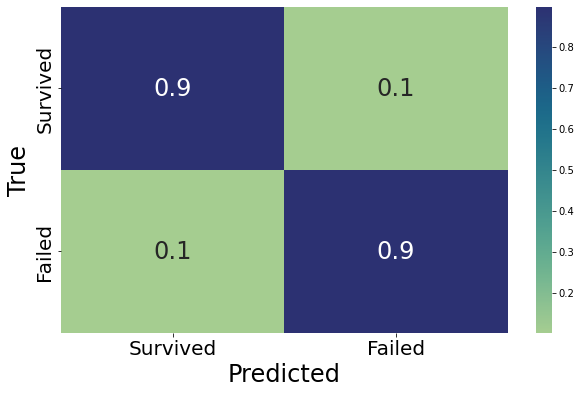

In [11]:
# constant for classes
classes = ('Survived', 'Failed')
plot_confusion(val_data, 'damage_state', 'damage_state_class_pred', classes)

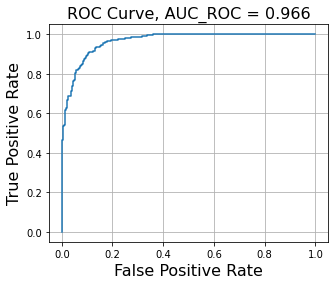

In [12]:
plot_auc_roc(val_data, 'damage_state', 'damage_state_pred')

,Survived,Failed
Survived,0.912426,0.087574
Failed,0.109924,0.890076


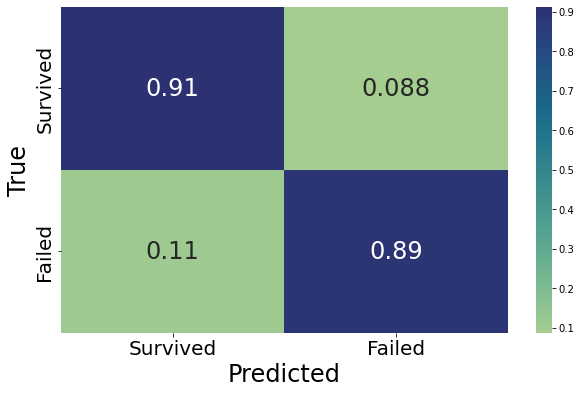

In [13]:
plot_confusion(train_data, 'damage_state', 'damage_state_class_pred', classes)

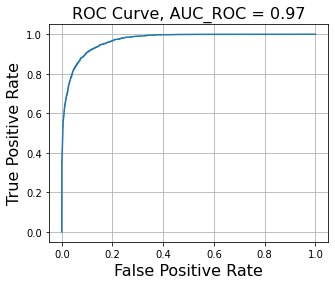

In [14]:
plot_auc_roc(train_data, 'damage_state', 'damage_state_pred')

## Loss Evolution

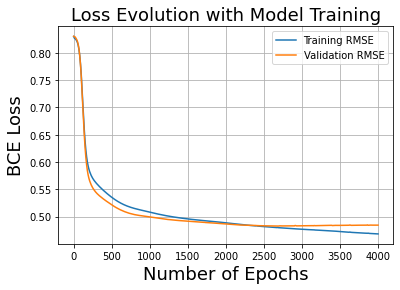

In [15]:
# Loss evolution curve
fig, ax = plt.subplots(1,1)
ax.plot(range(0, interval + max_epochs, interval), error_evolution_training, label = 'Training RMSE')
ax.plot(range(0, interval + max_epochs, interval), error_evolution_val, label = 'Validation RMSE')
# ax.set(title="Loss Evolution with Model Training", xlabel="Number of Epochs", ylabel="MSE Loss")
ax.set_title("Loss Evolution with Model Training", fontsize = 18)
ax.set_xlabel("Number of Epochs", fontsize = 18)
ax.set_ylabel("BCE Loss", fontsize = 18)
ax.legend()
ax.grid()
plt.show()

## Make Predictions on Test Data

In [16]:
y_pred_test = predict_tradnet(model, x_test)
test_data['damage_state_pred'] = y_pred_test.detach().view(-1).numpy()
test_data['damage_state_class_pred'] = test_data['damage_state_pred'].round().astype("int")

## Confusion Matrix on Test Data

,Survived,Failed
Survived,0.894354,0.105646
Failed,0.123099,0.876901


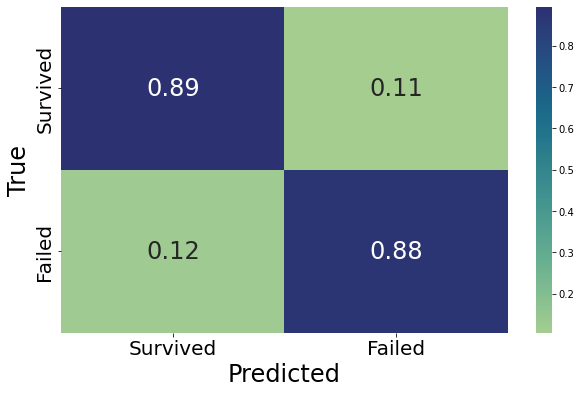

In [17]:
plot_confusion(test_data, 'damage_state', 'damage_state_class_pred', classes)

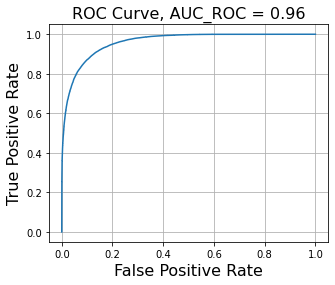

In [18]:
plot_auc_roc(test_data, 'damage_state', 'damage_state_pred')

In [19]:
accuracy_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.8868148539014576

In [20]:
roc_auc_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_pred']))

0.9603885185598404

## Confusion Matrix on Combined Train, Validation, and Test Data

,Survived,Failed
Survived,0.896267,0.103733
Failed,0.121459,0.878541


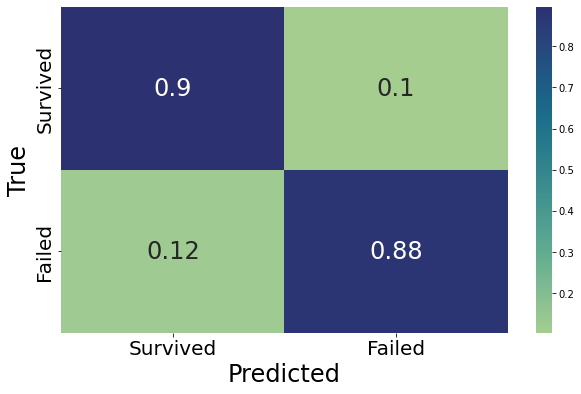

In [21]:
all_data = pd.concat([train_data, val_data, test_data]).reset_index(drop = True)
plot_confusion(all_data, 'damage_state', 'damage_state_class_pred', classes)

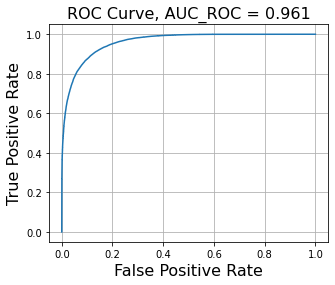

In [22]:
plot_auc_roc(all_data, 'damage_state', 'damage_state_pred')

## Compare Fragilities

In [23]:
fragility_df_gt = develop_fragility_model_stripe(all_data, 'pga', 'damage_state', bin_width = 0.1, 
                                                 max_im = 1.5, mu = 0.80, beta = 1.2)
fragility_df_pred = develop_fragility_model_stripe(all_data, 'pga', 'damage_state_class_pred', bin_width = 0.1, 
                                                   max_im = 1.5, mu = 0.80, beta = 1.2)

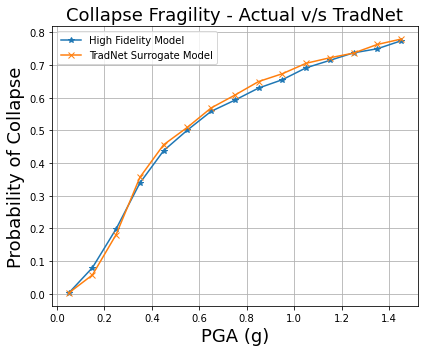

 Mean error = 0.01424, Max error = 0.022378


In [24]:
fig, ax = plt.subplots(1,1, figsize = (6, 5))

error_mean = (((fragility_df_gt['Probability'] - fragility_df_pred['Probability'])**2).mean())**0.5
error_max = (((fragility_df_gt['Probability'] - fragility_df_pred['Probability'])**2).max())**0.5

ax.plot(np.array(fragility_df_gt['IM']), np.array(fragility_df_gt['Probability']), '*-', label = 'High Fidelity Model')
ax.plot(np.array(fragility_df_pred['IM']), np.array(fragility_df_pred['Probability']), 'x-', label = 'TradNet Surrogate Model')
ax.legend()
ax.set_xlabel('PGA (g)', fontsize = 18)
ax.set_ylabel('Probability of Collapse', fontsize = 18)
ax.set_title('Collapse Fragility - Actual v/s TradNet', fontsize = 18)
ax.grid()

plt.tight_layout()
plt.show()

print(' Mean error = {}, Max error = {}'.format(round(error_mean,6), round(error_max,6)))

In [25]:
# fragility_df_pred.to_parquet('frag_df5_tradnet_new.parquet', engine = 'pyarrow')